# Trénovanie modelu iba na základe DST indexu 24h dopredu 6 dozadu
Súbor: 6_dozadu_24_dopredu.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [2]:
!nvidia-smi

Mon Mar 13 18:55:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:8B:00.0 Off |                  N/A |
| 30%   33C    P0    30W / 125W |    912MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [4]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'DST+24']
test = test[features]
train = train[features]
train = train.dropna()
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+24'

y_col='DST+24'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()
y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [5]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [6]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [7]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-03-13 18:55:47.505753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5765 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [8]:
# callbacks
saved_model = "6_dozadu_24_dopredu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [9]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-03-13 18:56:03.003498: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1139/1139 [==============================] - ETA: 0s - loss: 353.0066 - mae: 11.8906
Epoch 1: val_mae improved from inf to 11.99343, saving model to 6_dozadu_24_dopredu.hdf5
1139/1139 [==============================] - 76s 60ms/step - loss: 353.0066 - mae: 11.8906 - val_loss: 371.8419 - val_mae: 11.9934
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 329.7098 - mae: 11.5750
Epoch 2: val_mae did not improve from 11.99343
1139/1139 [==============================] - 68s 60ms/step - loss: 329.7098 - mae: 11.5750 - val_loss: 376.0140 - val_mae: 12.1343
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 325.0957 - mae: 11.5227
Epoch 3: val_mae improved from 11.99343 to 11.80224, saving model to 6_dozadu_24_dopredu.hdf5
1139/1139 [==============================] - 68s 60ms/step - loss: 325.0957 - mae: 11.5227 - val_loss: 369.7930 - val_mae: 11.8022
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 322.3194 - mae: 11.4797
Epoc

In [10]:
# load best model
model = keras.models.load_model('6_dozadu_24_dopredu.hdf5')

In [11]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 9s 14ms/step


In [ ]:
y_pred

In [12]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[113793  10887]
 [ 12716  17857]]


In [13]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91    124680
           1       0.62      0.58      0.60     30573

    accuracy                           0.85    155253
   macro avg       0.76      0.75      0.75    155253
weighted avg       0.84      0.85      0.85    155253



In [14]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [15]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,-4.0,5.427188
7,2004-07-22 05:00:00,-2.0,5.636433
8,2004-07-22 06:00:00,-1.0,6.371706
9,2004-07-22 07:00:00,-2.0,5.383048
10,2004-07-22 08:00:00,0.0,5.051101
...,...,...,...
155254,2022-04-28 20:00:00,-19.0,-20.616417
155255,2022-04-28 21:00:00,-10.0,-20.511898
155256,2022-04-28 22:00:00,-4.0,-18.896168
155257,2022-04-28 23:00:00,-4.0,-20.523872


In [16]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.806458,-11.338037
std,16.336765,11.570343
min,-374.000000,-63.628529
25%,-16.000000,-16.798178
50%,-7.000000,-8.919958
75%,0.000000,-3.330591
max,77.000000,11.173945


<AxesSubplot: >

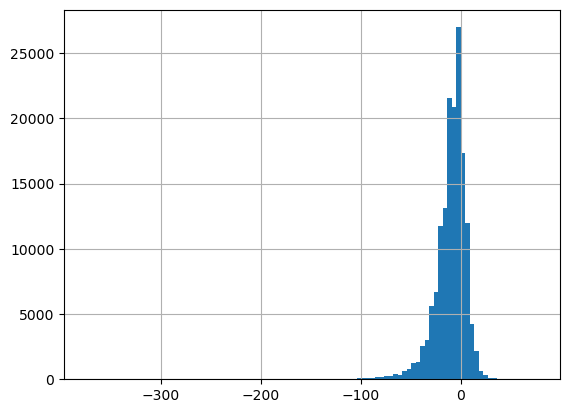

In [17]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

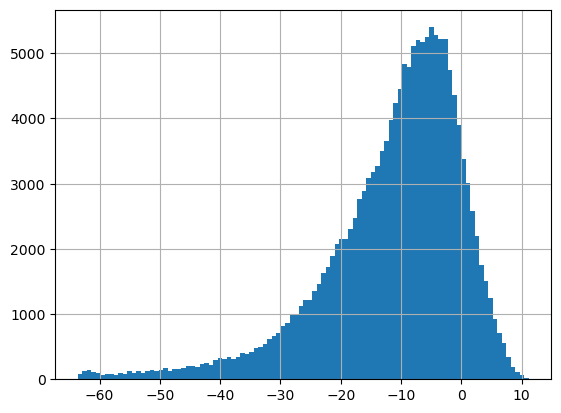

In [18]:
df["y_predict"].hist(bins=100)

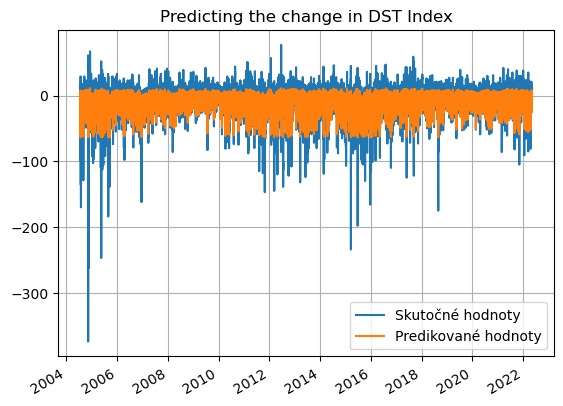

In [19]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [20]:
df.to_csv('predikcie_6h_dozadu_24h_dopredu.csv')

In [21]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

113793
10887
12716
17857
TPR=0.5840774539626468
TNR=0.9126804619826756
PPV=0.6212426941274701
NPV=0.8994854121050676
FPR=0.08731953801732435
FNR=0.41592254603735324
FDR=0.3787573058725299
ACC=0.8479707316444771
MCC=0.5086018175608792
